Profit function (Paquette Loss):  
$$\Pi:= \sum_{\textit{weeks with output } 1} 1\cdot(Close-Open)+\sum_{\textit{weeks with output } -1} -1\cdot(Close-Open)= \sum_{\textit{all weeks}} Output_{week}\cdot(Close-Open)$$

In [1]:
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import sys
#sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')
sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [104]:
#msft = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Microsoft_weekly_ok.csv')
#amzn = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Amazon_weekly_ok.csv')
amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', index_col=False, parse_dates=['Date'])
#ibm = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\IBM_weekly_ok.csv')
#cac = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Cac_weekly_ok.csv')
#sp500 = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Sp500_weekly_ok.csv')
#nasdaq = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Nasdaq_weekly_ok.csv')

In [103]:
# Function to add indicators
def calculate_indicators(df, rsi_period=14, cci_period=20, ema_short_period=10, ema_long_period=40, cpc_window=4):

    ema_short_column = f'EMA{ema_short_period}'
    ema_long_column = f'EMA{ema_long_period}'
    ema_difference_column = f'EMA{ema_short_period}_EMA{ema_long_period}_Difference_Normalized'

    # Calculate short and long period exponential moving averages
    df[ema_short_column] = df['Close'].ewm(span=ema_short_period, adjust=False).mean()
    df[ema_long_column] = df['Close'].ewm(span=ema_long_period, adjust=False).mean()

    # Calculate the difference of exponential moving averages
    df[ema_difference_column] = (df[ema_short_column] - df[ema_long_column])/df[ema_long_column]

    # Calculate RSI (Relative Strength Index)
    price_change = df['Close'].diff()
    upward_changes = price_change.clip(lower=0)
    downward_changes = -price_change.clip(upper=0)
    average_upward_changes = upward_changes.rolling(window=rsi_period).mean()
    average_downward_changes = downward_changes.rolling(window=rsi_period).mean()
    relative_strength = average_upward_changes / average_downward_changes
    df['RSI'] = 100 - (100 / (1 + relative_strength))

    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_typical_price = typical_price.rolling(window=cci_period).mean()
    mean_deviation = (typical_price - sma_typical_price).abs().rolling(window=cci_period).mean()
    df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)

    # Calculate CPC (Current Price Change)
    rolling_mean_close = df['Close'].rolling(cpc_window).mean()
    df['CPC'] = 1 / (1 + np.exp(-(df['Close'] - rolling_mean_close.shift(1)) / rolling_mean_close.shift(1) * 100))
    
    #df.drop(columns=[ema_short_column, ema_long_column], inplace=True)
    
    return df

In [105]:
# List of DataFrames
#dfs = [amzn, cac, ibm, msft, nasdaq, sp500]
dfs=[amzn]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)
    
    calculate_indicators(df, rsi_period=4, cci_period=6, ema_short_period=4, ema_long_period=10, cpc_window=4)

In [106]:
amzn.head(41)

,Date,Open,High,Low,Close,EMA4,EMA10,EMA4_EMA10_Difference_Normalized,RSI,CCI,CPC
0,1997-05-18,0.075000,0.125000,0.075000,0.086460,0.086460,0.086460,0.000000,NaN,NaN,NaN
1,1997-05-25,0.088021,0.088542,0.065625,0.075000,0.081876,0.084376,-0.029633,NaN,NaN,NaN
2,1997-06-01,0.075521,0.082292,0.072917,0.075000,0.079126,0.082672,-0.042892,NaN,NaN,NaN
3,1997-06-08,0.075521,0.085417,0.068750,0.082815,0.080601,0.082698,-0.025349,NaN,NaN,NaN
4,1997-06-15,0.082812,0.085417,0.076562,0.079170,0.080029,0.082056,-0.024708,34.096859,NaN,0.307299
5,1997-06-22,0.080208,0.080208,0.074740,0.076305,0.078539,0.081011,-0.030506,54.554974,NaN,0.102627
6,1997-06-29,0.077083,0.077083,0.073958,0.074480,0.076916,0.079823,-0.036426,48.390093,NaN,0.007348
7,1997-07-06,0.075521,0.095833,0.073958,0.095575,0.084379,0.082687,0.020465,71.678559,NaN,1.000000
8,1997-07-13,0.091667,0.128646,0.091667,0.114585,0.096462,0.088487,0.090125,89.530081,NaN,1.000000
9,1997-07-20,0.116146,0.124740,0.105729,0.107815,0.101003,0.092001,0.097846,82.351129,NaN,1.000000


In [107]:
# Drop rows with na, depending on parameters chosen for indicators
amzn.dropna(inplace=True)
amzn.reset_index(inplace=True)

In [7]:
amzn.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close',
       'MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC'],
      dtype='object')

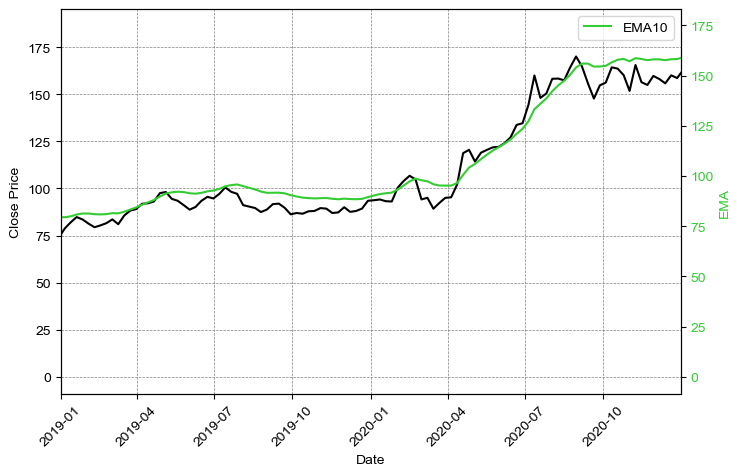

In [116]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

#ax.legend()

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMA10'], color='#33CC33', label='EMA10')
ax2.set_ylabel('EMA', color='#33CC33')
ax2.tick_params(axis='y', labelcolor='#33CC33')
ax2.legend(loc='upper right')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMA.png', transparent=True)
plt.show()

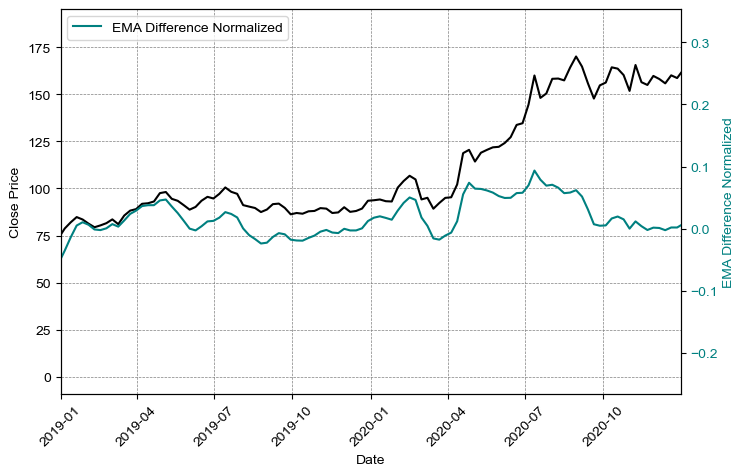

In [117]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

#ax.legend()

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMA4_EMA10_Difference_Normalized'], color='#008080', label='EMA Difference Normalized')
ax2.set_ylabel('EMA Difference Normalized', color='#008080')
ax2.tick_params(axis='y', labelcolor='#008080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMADN.png', transparent=True)
plt.show()

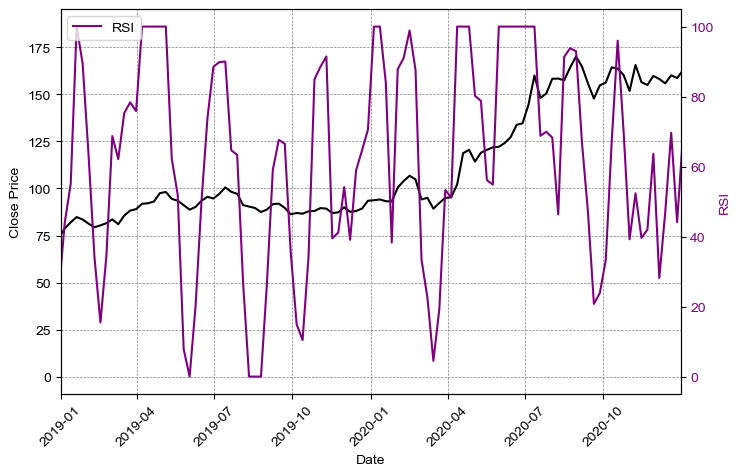

In [118]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='#800080', label='RSI')
ax2.set_ylabel('RSI', color='#800080')
ax2.tick_params(axis='y', labelcolor='#800080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('RSI.png', transparent=True)
plt.show()

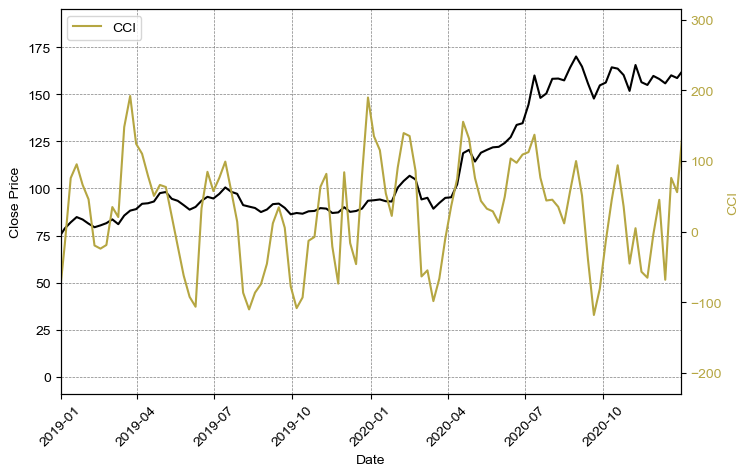

In [119]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='#B5A642', label='CCI')
ax2.set_ylabel('CCI', color='#B5A642')
ax2.tick_params(axis='y', labelcolor='#B5A642')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CCI.png', transparent=True)

plt.show()

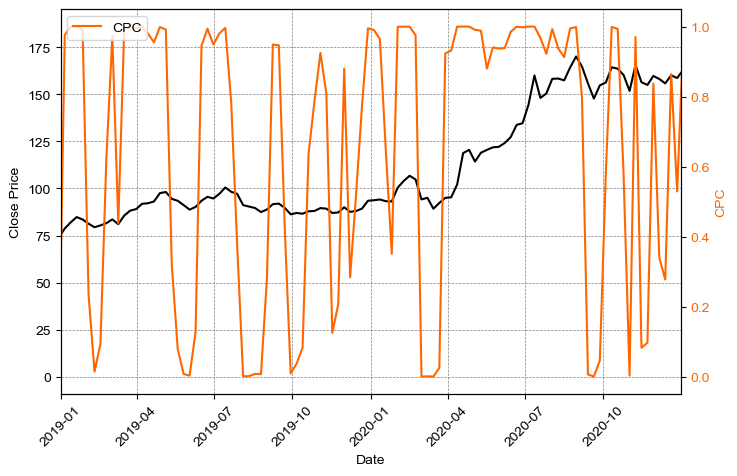

In [120]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='#FF6600', label='CPC')
ax2.set_ylabel('CPC', color='#FF6600')
ax2.tick_params(axis='y', labelcolor='#FF6600')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CPC.png', transparent=True)

plt.show()

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [123]:
# Calculate the percentage change in closing price from one week to the next
amzn.copy()
amzn.loc[:, 'Current_week_pct_change'] = 100*(amzn['Close'].pct_change(periods=1))
amzn.loc[:, 'Next_week_pct_change'] = 100*(amzn['Close'].pct_change(periods=1).shift(-1))

# Define a threshold for what we consider to be a flat week, e.g. 1% price change
# Define a function to categorize the change as +1, 0, or -1
def categorize_change(weekly_return, flat_threshold=1):
    if weekly_return > flat_threshold:
        return 1  # Bullish
    elif weekly_return < -flat_threshold:
        return -1  # Bearish
    else:
        return 0  # Flat

# Apply the function to the percentage change column to create the target variable
amzn.loc[:, 'Next_week_market_behavior'] = amzn['Next_week_pct_change'].apply(categorize_change)
amzn.loc[:, 'Log_return'] = np.log(amzn['Close'].shift(-1) / amzn['Close'])

# Drop the last row as it contains NaN in the 'Next_week_pct_change' column
amzn = amzn[1:-1]

In [133]:
amzn

,index,Date,Open,High,Low,Close,EMA4,EMA10,EMA4_EMA10_Difference_Normalized,RSI,CCI,CPC,Current_week_pct_change,Next_week_pct_change,Next_week_market_behavior,Log_return
1,11,1997-08-03,0.111458,0.125260,0.110937,0.120835,0.111445,0.100138,0.112916,82.551546,71.517896,0.999996,8.411089,-5.172342,-1,-0.053109
2,12,1997-08-10,0.118750,0.120573,0.105208,0.114585,0.112701,0.102765,0.096690,50.000000,18.127202,0.690324,-5.172342,-7.727888,-1,-0.080428
3,13,1997-08-17,0.114583,0.116667,0.096875,0.105730,0.109913,0.103304,0.063973,46.293333,-26.389914,0.000922,-7.727888,0.491819,0,0.004906
4,14,1997-08-24,0.102604,0.110417,0.098437,0.106250,0.108448,0.103840,0.044376,39.580000,-35.844654,0.002237,0.491819,10.051765,1,0.095781
5,15,1997-08-31,0.105208,0.119792,0.105208,0.116930,0.111841,0.106220,0.052917,42.577457,20.988256,0.989458,10.051765,6.901565,1,0.066738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,1393,2024-01-28,156.890000,160.720000,153.900000,159.120000,155.268272,150.686373,0.030407,67.444121,93.584108,0.992096,2.433372,7.975113,1,0.076731
1384,1394,2024-02-04,159.340000,172.500000,154.810000,171.810000,161.884963,154.527032,0.047616,100.000000,166.283963,0.999993,7.975113,1.536581,1,0.015249
1385,1395,2024-02-11,170.200000,175.000000,167.650000,174.450000,166.910978,158.149390,0.055401,100.000000,150.134336,0.999861,1.536581,-2.831757,-1,-0.028726
1386,1396,2024-02-18,174.800000,175.390000,165.750000,169.510000,167.950587,160.214956,0.048283,79.459459,73.671988,0.932225,-2.831757,3.232848,1,0.031817


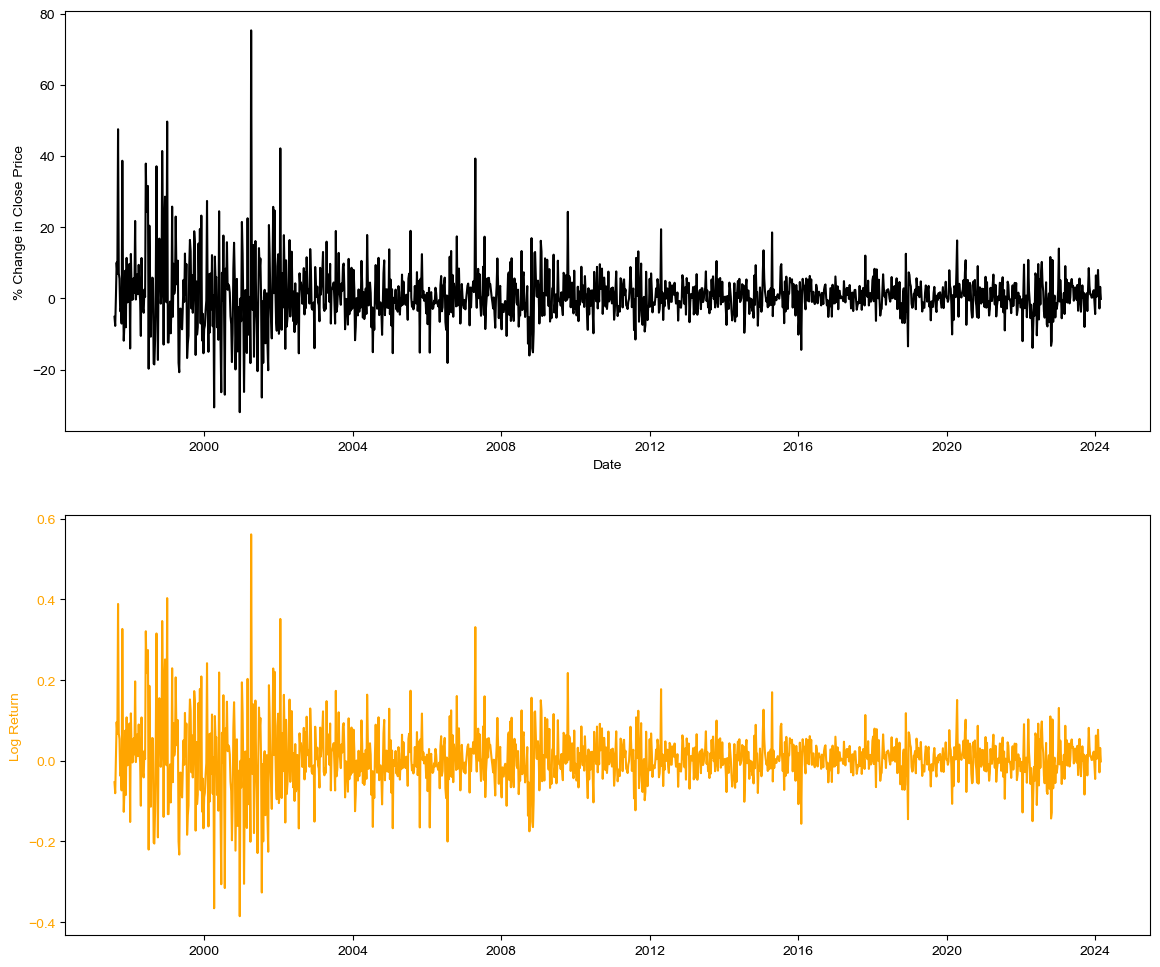

In [124]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 12))
axes[0].plot(amzn['Date'], amzn['Next_week_pct_change'], color='Black', label='% change')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('% Change in Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

axes[1].plot(amzn['Date'], amzn['Log_return'], color='orange', label='Log Return')
axes[1].set_ylabel('Log Return', color='orange')
axes[1].tick_params(axis='y', labelcolor='orange')

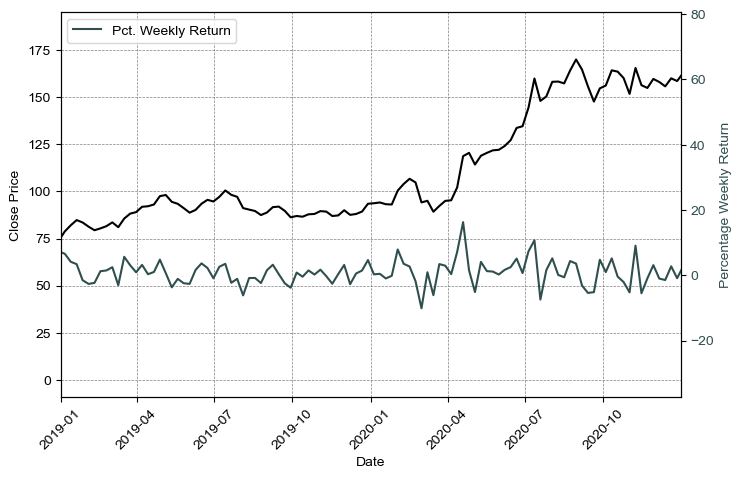

In [131]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['Current_week_pct_change'], color='#2F4F4F', label='Pct. Weekly Return')
ax2.set_ylabel('Percentage Weekly Return', color='#2F4F4F')
ax2.tick_params(axis='y', labelcolor='#2F4F4F')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('PercentageReturn.png', transparent=True)

plt.show()

In [16]:
amzn.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close',
       'MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC',
       'Current_week_pct_change', 'Next_week_pct_change',
       'Next_week_market_behavior', 'Log_return'],
      dtype='object')

In [134]:
# Define your feature columns
feature_columns = ['EMA4_EMA10_Difference_Normalized', 'RSI', 'CCI', 'CPC', 'Current_week_pct_change']

# Now let's prepare the features
features = amzn[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
print(features)

# Prepare the target to fit the labeling {0,1,2}
target = amzn['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.8)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

[[6.23118571e-01 8.25515464e-01 5.58607803e-01 9.99996464e-01
  3.76536712e-01]
 [5.94298292e-01 5.00000000e-01 4.50975823e-01 6.90324385e-01
  2.49868170e-01]
 [5.36187909e-01 4.62933333e-01 3.61232367e-01 9.21854495e-04
  2.26037139e-01]
 ...
 [5.20961050e-01 1.00000000e+00 7.17093159e-01 9.99860853e-01
  3.12430385e-01]
 [5.08318390e-01 7.94594595e-01 5.62950304e-01 9.32225122e-01
  2.71694654e-01]
 [5.08314988e-01 8.08155340e-01 5.28174414e-01 9.76216201e-01
  3.28248450e-01]]


In [135]:
# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('MADN', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('RETURN',[
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ])
]

model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

#coeff_shape = torch.Size([model.num_rules, model.num_classes, model.num_in+1])

# Initialize the consequent parameters and set them to small (10^-2) random values using the coeff property setter
#model.coeff = torch.randn(coeff_shape, dtype=torch.float) * 1

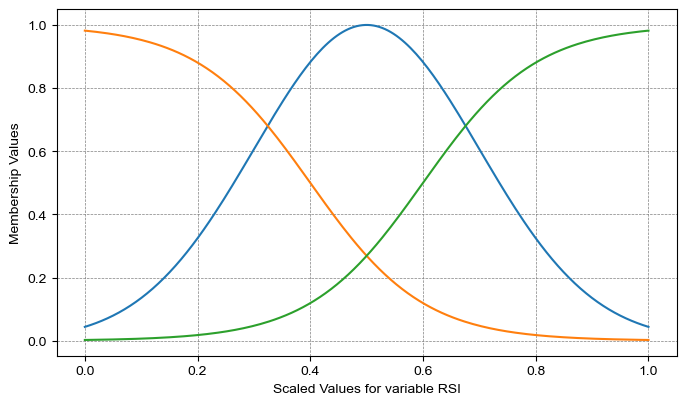

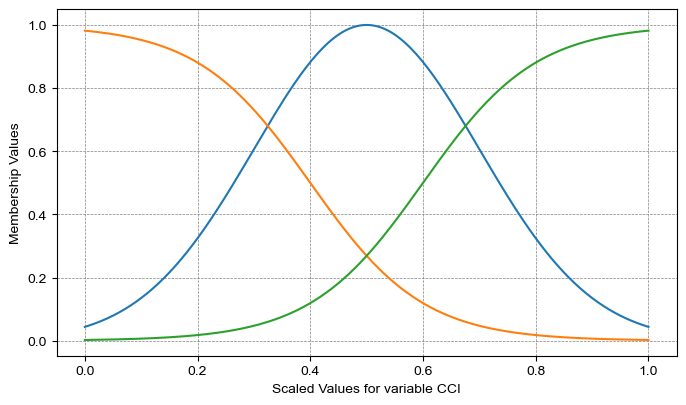

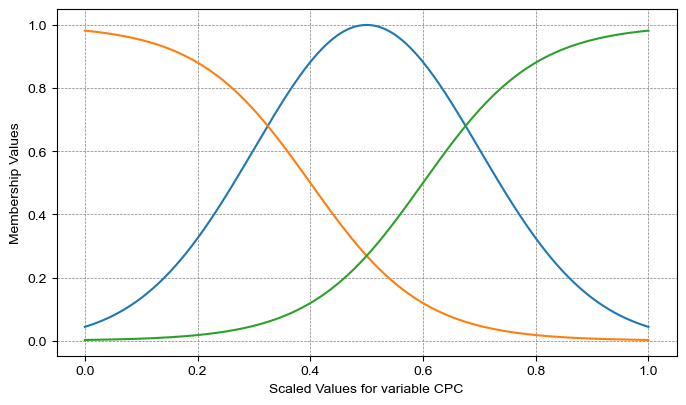

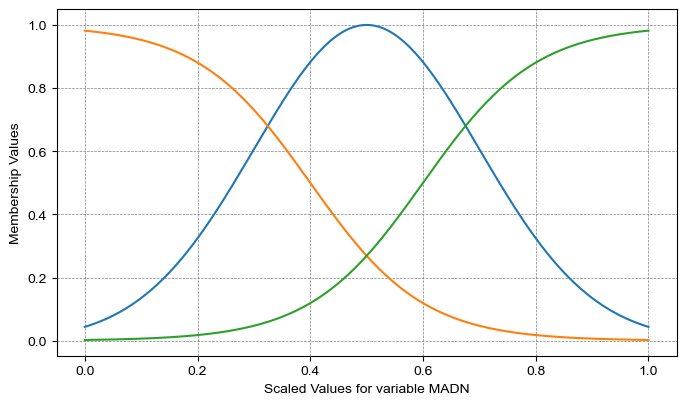

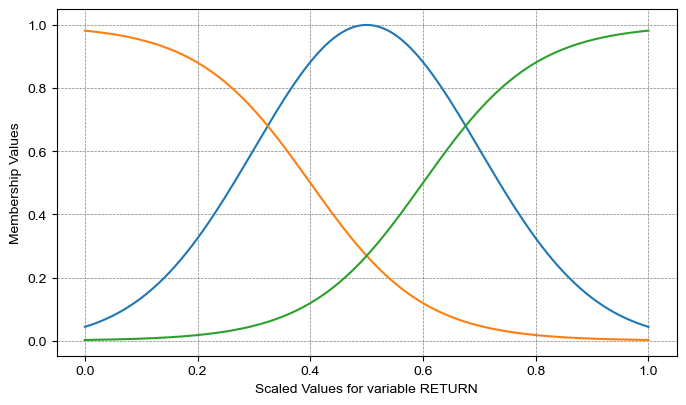

In [136]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

In [137]:
model.coeff

Parameter containing:
tensor([[[ 0.0142, -0.0379, -0.0026,  0.0244,  0.0079, -0.0200],
         [-0.0778, -0.0963,  0.1459,  0.1213,  0.1942, -0.0463],
         [ 0.0440, -0.0641, -0.0211, -0.0673, -0.1944, -0.0696]],

        [[ 0.1056,  0.0866,  0.1408, -0.0985, -0.2262, -0.0153],
         [-0.0821, -0.0823,  0.1614,  0.0246,  0.0739, -0.0164],
         [ 0.0248, -0.1243, -0.0033, -0.0427, -0.0648,  0.1322]],

        [[ 0.0175, -0.1554,  0.0752,  0.0963,  0.1618,  0.2081],
         [-0.0732,  0.0225, -0.0585,  0.1153,  0.1546,  0.1486],
         [-0.1940, -0.0480, -0.0717, -0.1194, -0.0880,  0.0968]],

        ...,

        [[-0.1060,  0.0589, -0.1916,  0.1019, -0.0453,  0.0067],
         [-0.2217, -0.1595,  0.0742,  0.0309, -0.1025,  0.0809],
         [-0.0228, -0.0306,  0.1179,  0.0688,  0.0738,  0.0058]],

        [[ 0.0136, -0.0023,  0.1336,  0.0530, -0.1008, -0.1748],
         [-0.0958, -0.0196, -0.0421,  0.0694, -0.1291,  0.1469],
         [ 0.0280, -0.0873, -0.0298,  0.1593, 

### Training for 300 epochs, training size = 1109 cases
epoch    0: Loss=1.09448
epoch   10: Loss=1.02688
epoch   20: Loss=1.01395
epoch   30: Loss=1.00444
epoch   40: Loss=0.99193
epoch   50: Loss=0.98612
epoch   60: Loss=0.98368
epoch   70: Loss=0.98201
epoch   80: Loss=0.98029
epoch   90: Loss=0.97715
epoch  100: Loss=0.97396
epoch  110: Loss=0.97018
epoch  120: Loss=0.96611
epoch  130: Loss=0.96312
epoch  140: Loss=0.96067
epoch  150: Loss=0.95892
epoch  160: Loss=0.95822
epoch  170: Loss=0.95694
epoch  180: Loss=0.95604
epoch  190: Loss=0.95596
epoch  200: Loss=0.95581
epoch  210: Loss=0.95421
epoch  220: Loss=0.95397
epoch  230: Loss=0.95480
epoch  240: Loss=0.95522
epoch  250: Loss=0.95362
epoch  260: Loss=0.95345
epoch  270: Loss=0.95517
epoch  280: Loss=0.95441
epoch  290: Loss=0.95576
epoch  299: Loss=0.95464


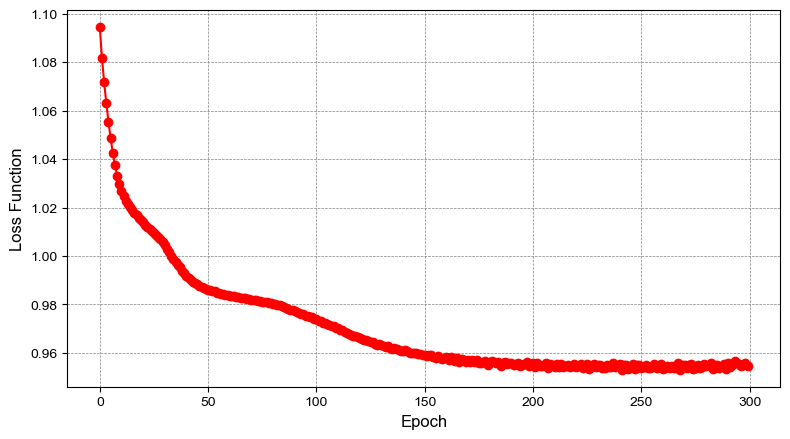

In [138]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
experimental.train_anfis_classifier_with(model=model, data=train_loader, optimizer=optimizer, epochs=300, show_plots=True)

In [139]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
predict_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels=experimental.classification_predictions(model, predict_loader)

In [140]:
actual_labels=y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
print('Confusion Matrix:\n', conf_matrix)

# Classification Report
class_report = classification_report(actual_labels, predicted_labels)
print('Classification Report:\n', class_report)

Accuracy: 0.51
Confusion Matrix:
 [[239   8 185]
 [ 73  20  88]
 [184   8 304]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.55      0.52       432
           0       0.56      0.11      0.18       181
           1       0.53      0.61      0.57       496

    accuracy                           0.51      1109
   macro avg       0.52      0.43      0.42      1109
weighted avg       0.51      0.51      0.48      1109



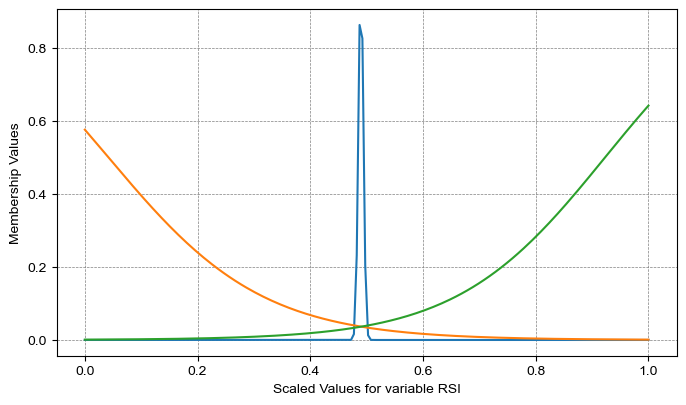

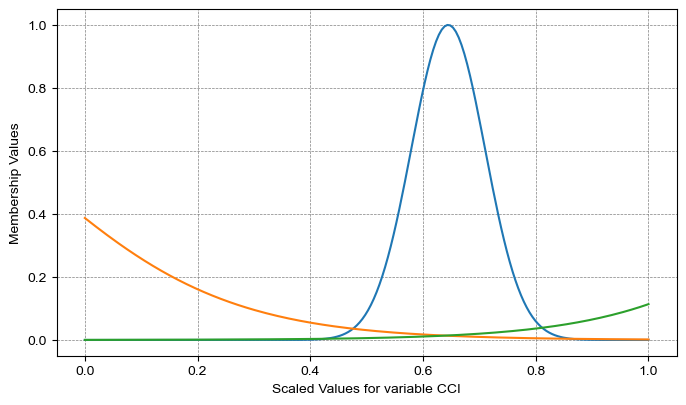

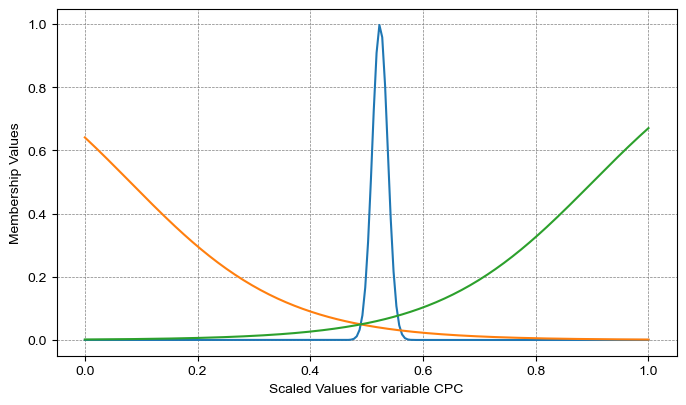

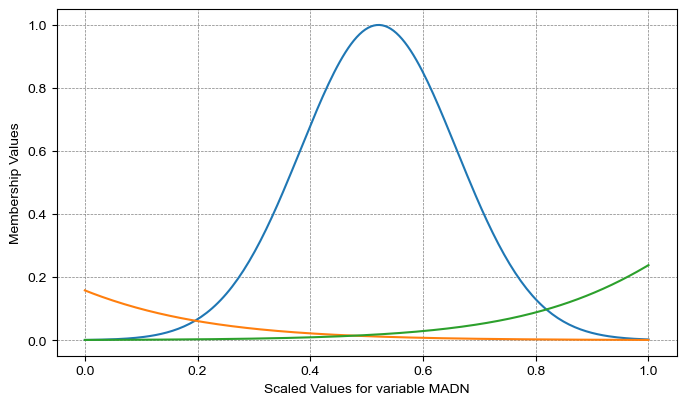

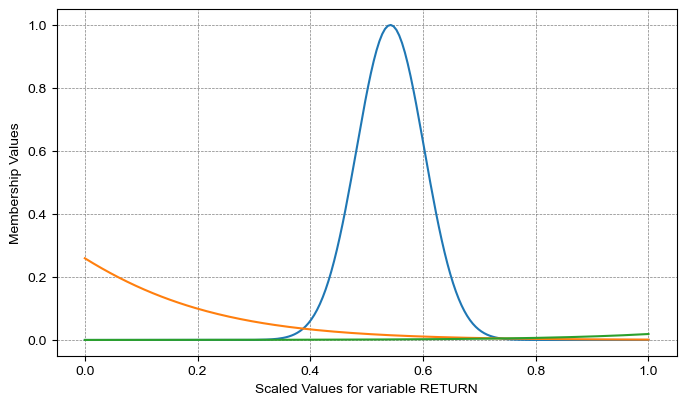

In [141]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(model, x)

In [6]:
regression_data=pd.DataFrame()
regression_target=pd.DataFrame()

regression_data['xtp6']=amzn['Current_week_pct_change'].shift(-6)
regression_data['xt']=amzn['Current_week_pct_change']
regression_data['xtm6']=amzn['Current_week_pct_change'].shift(6)
regression_data['xtm12']=amzn['Current_week_pct_change'].shift(12)
regression_data['xtm18']=amzn['Current_week_pct_change'].shift(18)

regression_data.dropna(inplace=True)

regression_target['xtp6']=regression_data['xtp6']
regression_data.drop(columns=['xtp6'], inplace=True)

scaler=MinMaxScaler()

regression_data=scaler.fit_transform(regression_data)
regression_target=scaler.fit_transform(regression_target)

print(regression_data)
print(regression_target)

[[0.34978356 0.22603714 0.56222011 0.17449852]
 [0.26430708 0.30268774 0.48358142 0.29810142]
 [0.27148911 0.39183638 0.24300541 0.39527026]
 ...
 [0.28910564 0.30862445 0.30426346 0.29838142]
 [0.25698058 0.30812164 0.31143775 0.33211057]
 [0.35832629 0.29994435 0.26490739 0.29884409]]
[[0.18726418]
 [0.2330422 ]
 [0.3703676 ]
 ...
 [0.31243038]
 [0.27169465]
 [0.32824845]]


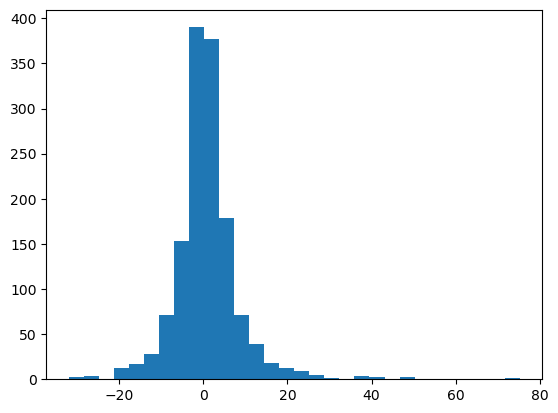

In [7]:
plt.hist(amzn['Current_week_pct_change'], bins=30)
plt.show()

In [8]:
amzn['Current_week_pct_change'].describe()

count    1397.000000
mean        0.832673
std         7.781058
min       -31.967213
25%        -2.644136
50%         0.358151
75%         3.653846
max        75.268817
Name: Current_week_pct_change, dtype: float64

In [9]:
invardefs = [
            ('xtm18', membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ('xtm12', membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ('xtm6',  membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ('xt',    membership.make_bell_mfs(0.2, 3, [0.33, 0.66])),
            ]
outvars = ['xtp6']
regression_model = anfis.AnfisNet('Time series regression', invardefs, outvars, hybrid=True)

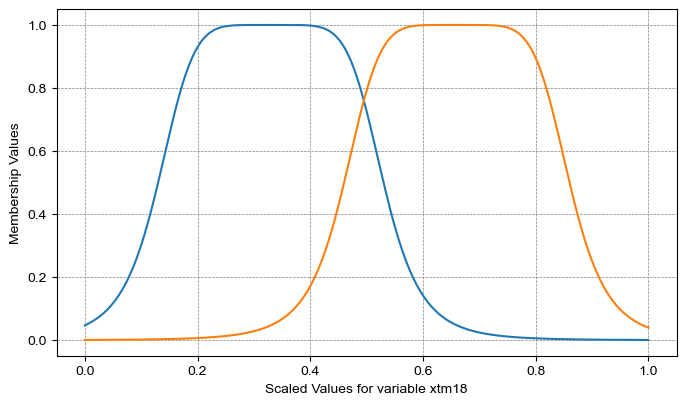

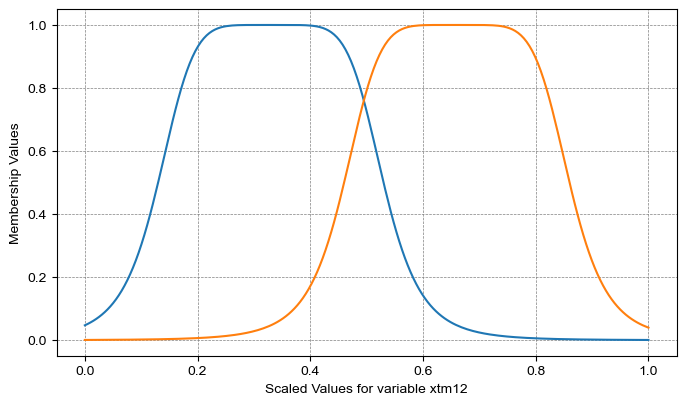

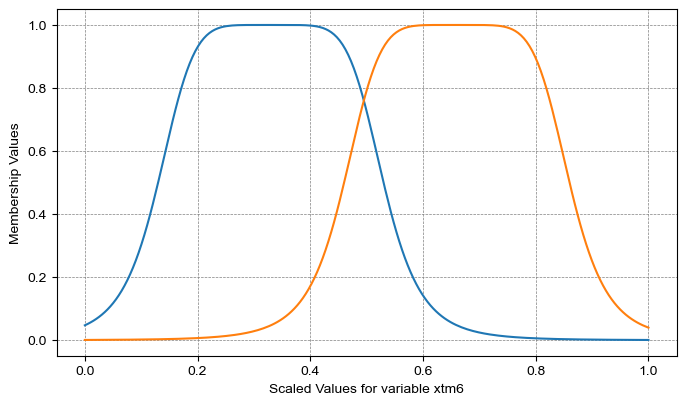

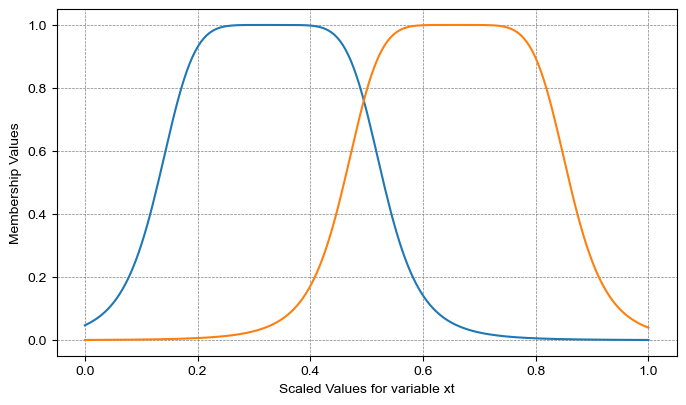

In [31]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)

# Ensure the order matches 'feature_columns' and the model's expectations
x = torch.stack([points_range, points_range, points_range, points_range], dim=1)  # Adjust the order if necessary

# Now call the plotting function, ensuring your model and the function are ready to use
experimental.plot_all_mfs(regression_model, x)

In [10]:
# Calculate the index for the split
split_idx = int(len(regression_data) * 0.8)

# Split the features and target into training/testing sets without shuffling
X_train = regression_data[:split_idx]
X_test = regression_data[split_idx:]
y_train = regression_target[:split_idx]
y_test = regression_target[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [11]:
experimental.train_anfis(regression_model, train_loader, 500, show_plots=True)

### Training for 500 epochs, training size = 1098 cases


AssertionError: Coeff shape should be torch.Size([16, 1, 5]), but is actually torch.Size([16, 80, 5])

In [18]:
import sys
import itertools
import numpy as np

sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')

import torch
from torch.utils.data import TensorDataset, DataLoader

import anfis
from membership import BellMembFunc, make_bell_mfs
from experimental import train_anfis, test_anfis

dtype = torch.float


def ex4_model():
    '''
        Example 4 model, from Jang's data; 4 variables with 2 MFs each.
        Predict x(t+6) based on x(t-18), x(t-12), x(t-6), x(t)
        These are the starting MFs values he suggests.
    '''
    invardefs = [
            ('xm18', make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ('xm12', make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ('xm6',  make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ('x',    make_bell_mfs(0.444045, 2, [0.425606, 1.313696])),
            ]
    outvars = ['xp6']
    model = anfis.AnfisNet('Jang\'s example 4', invardefs, outvars)
    return model


def jang_ex4_trained_model():
    '''
        Example 4 model, from Jang's data; 4 variables with 2 MFs each.
        These are the final 'trained' values from pg. 683.
    '''
    # Data from Table VI:
    mfs = [
        (0.1790, 2.0456, 0.4798),  # SMALL1
        (0.1584, 2.0103, 1.4975),  # LARGE1
        (0.2410, 1.9533, 0.2960),  # SMALL2
        (0.2923, 1.9178, 1.7824),  # LARGE2
        (0.3798, 2.1490, 0.6599),  # SMALL3
        (0.4884, 1.8967, 1.6465),  # LARGE3
        (0.2815, 2.0170, 0.3341),  # SMALL4
        (0.1616, 2.0165, 1.4727),  # LARGE4
    ]
    invardefs = [
            ('xm18', [BellMembFunc(*mfs[0]), BellMembFunc(*mfs[1])]),
            ('xm12', [BellMembFunc(*mfs[2]), BellMembFunc(*mfs[3])]),
            ('xm6',  [BellMembFunc(*mfs[4]), BellMembFunc(*mfs[5])]),
            ('x',    [BellMembFunc(*mfs[6]), BellMembFunc(*mfs[7])]),
            ]
    outvars = ['xp6']
    model = anfis.AnfisNet('Jang\'s example 4 (trained)', invardefs, outvars)
    # Jang calls this "the parameter matrix C" on pg 683:
    coeff = torch.tensor([
        [0.2167,   0.7233, -0.0365,  0.5433,  0.0276],
        [0.2141,   0.5704, -0.4826,  1.2452, -0.3778],
        [-0.0683,  0.0022,  0.6495,  2.7320, -2.2916],
        [-0.2616,  0.9190, -2.9931,  1.9467,  1.6555],
        [-0.3293, -0.8943,  1.4290, -1.6550,  2.3735],
        [2.5820,  -2.3109,  3.7925, -5.8068,  4.0478],
        [0.8797,  -0.9407,  2.2487,  0.7759, -2.0714],
        [-0.8417, -1.5394, -1.5329,  2.2834,  2.4140],
        [-0.6422, -0.4384,  0.9792, -0.3993,  1.5593],
        [1.5534,  -0.0542, -4.7256,  0.7244,  2.7350],
        [-0.6864, -2.2435,  0.1585,  0.5304,  3.5411],
        [-0.3190, -1.3160,  0.9689,  1.4887,  0.7079],
        [-0.3200, -0.4654,  0.4880, -0.0559,  0.9622],
        [4.0220,  -3.8886,  1.0547, -0.7427, -0.4464],
        [0.3338,  -0.3306, -0.5961,  1.1220,  0.3529],
        [-0.5572,  0.9190, -0.8745,  2.1899, -0.9497],
    ])
    model.coeff = coeff.unsqueeze(1)  # add extra dim for output vars
    return model


def jang_ex4_data(filename):
    '''
        Read Jang's data for the MG function to be modelled.
    '''
    num_cases = 500
    x = torch.zeros((num_cases, 4))
    y = torch.zeros((num_cases, 1))
    with open(filename, 'r') as fh:
        for i, line in enumerate(fh):
            values = [float(v) for v in line.strip().split()]
            x[i] = torch.tensor(values[0:4])
            y[i] = values[4]
    dl = DataLoader(TensorDataset(x, y), batch_size=1024, shuffle=True)
    return dl

show_plots = True
model = ex4_model()
train_data = jang_ex4_data('jang-example4-data.trn')
train_anfis(model, train_data, 500, show_plots)
test_data = jang_ex4_data('jang-example4-data.chk')
test_anfis(model, test_data, show_plots)
'''
model = jang_ex4_trained_model()
test_data = jang_ex4_data('jang-example4-data.trn')
test_anfis(model, test_data, show_plots)
test_data = jang_ex4_data('jang-example4-data.chk')
test_anfis(model, test_data, show_plots)
'''

### Training for 500 epochs, training size = 500 cases


AssertionError: Coeff shape should be torch.Size([16, 1, 5]), but is actually torch.Size([16, 80, 5])